<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/age1SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=f8df1af1ded74f1c9318c0803515f27ebea84dca3ced9c142b504d1e186a4e8a
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("Agenormalized_with_winners_cleaned.csv")

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative'])]
filtered_data = filtered_data.reset_index(drop=True)


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    #'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    #'Green': (0, 0.6, 0.3),         # Dark Green
    #'The Brexit Party': (0.6, 0.2, 0.8) #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = filtered_data[labeling_columns]

print(normalized_df.head())
print(normalized_df.shape[0])
print(normalized_df.isnull().sum())

   Aged 15 years and under  Aged 16 to 24 years  Aged 25 to 34 years  \
0                 0.222092             0.090002             1.080024   
1                -0.199337            -0.111272            -0.434910   
2                 1.061427            -0.478784            -0.873616   
3                -0.476328            -0.211372            -0.051715   
4                -0.014245            -0.006039            -0.093409   

   Aged 35 to 49 years  Aged 50 to 64 years  Aged 65 years and over  \
0             0.624195            -0.418428               -0.513742   
1            -0.576573             0.362650                0.564869   
2             0.916699            -0.234931               -0.041974   
3            -0.475153             0.511035                0.414003   
4            -0.426279             0.343624                0.239917   

  Westminster Parliamentary constituencies Winning Party  Winning Vote Share  
0                                aldershot  Conservative     

In [3]:
# import math
# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)

# Train the SOM
num_iterations = 3000
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.43570592061343083


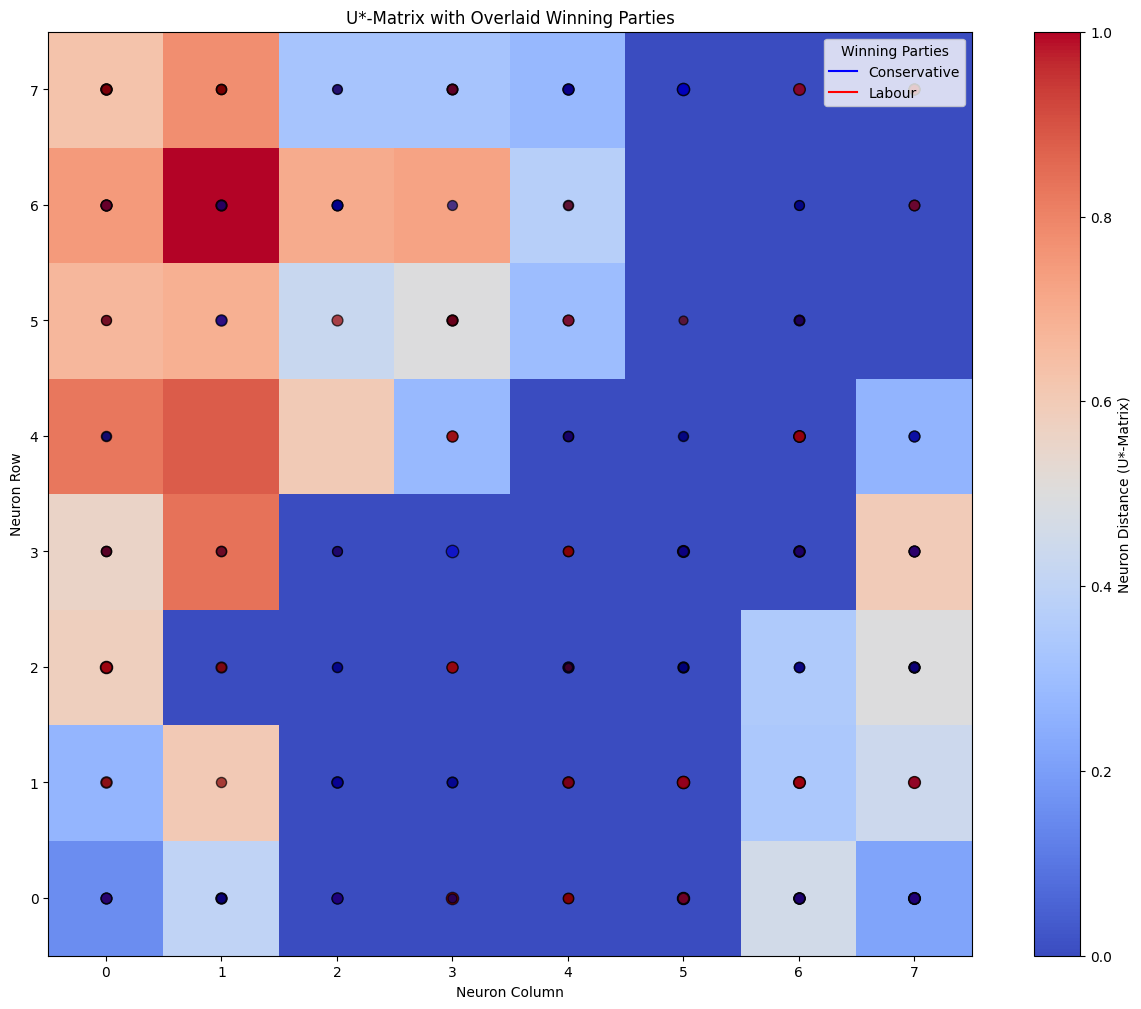

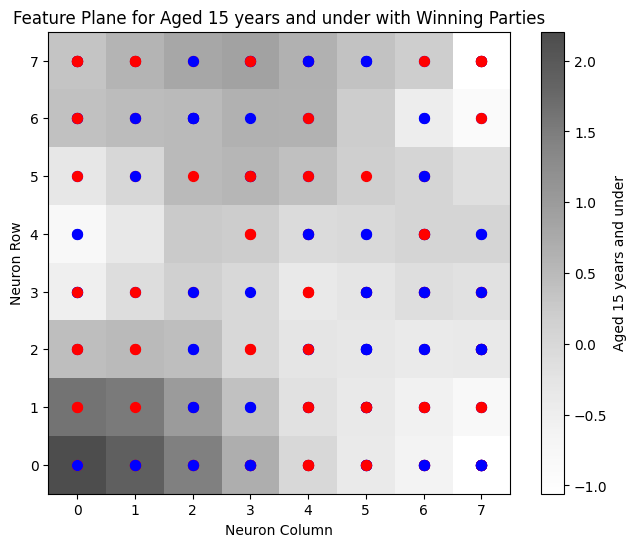

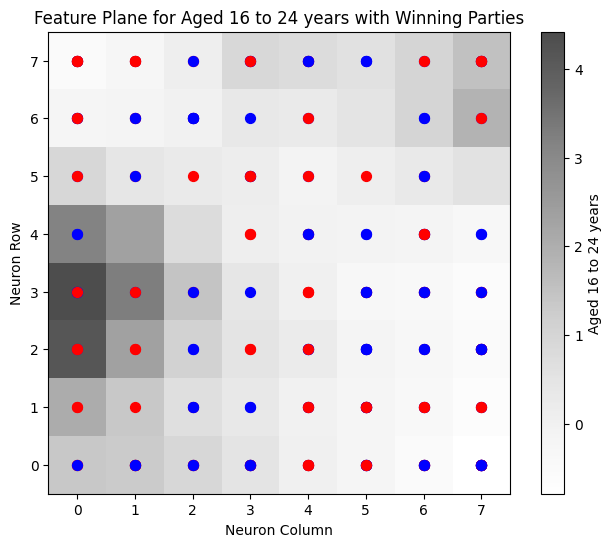

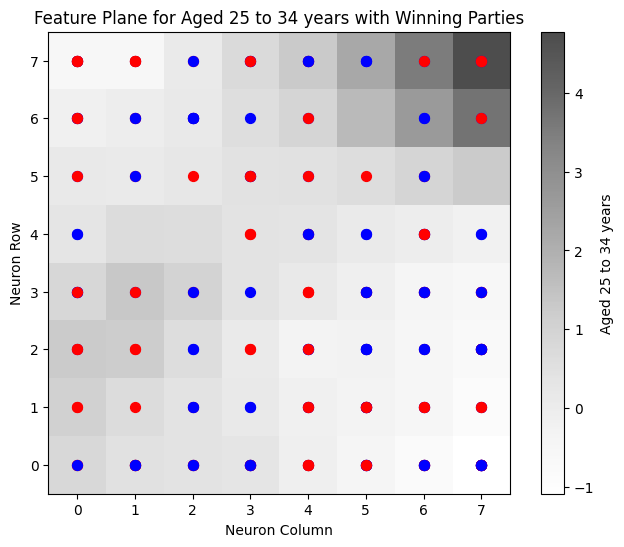

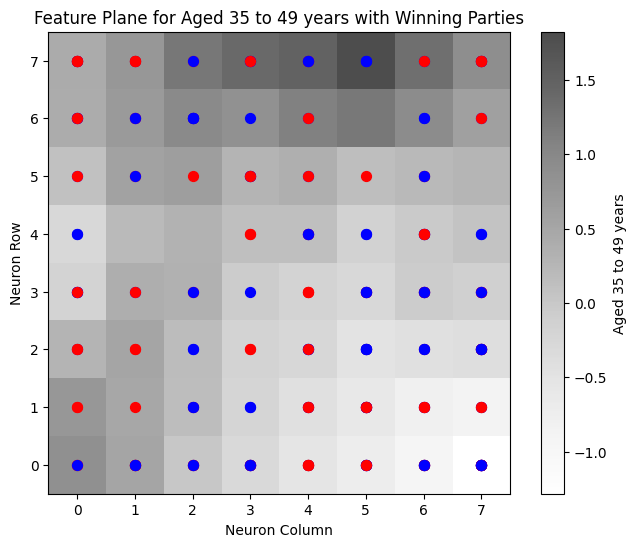

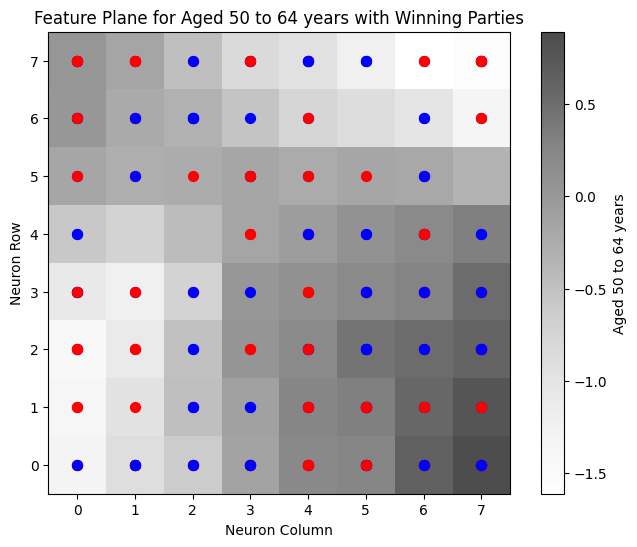

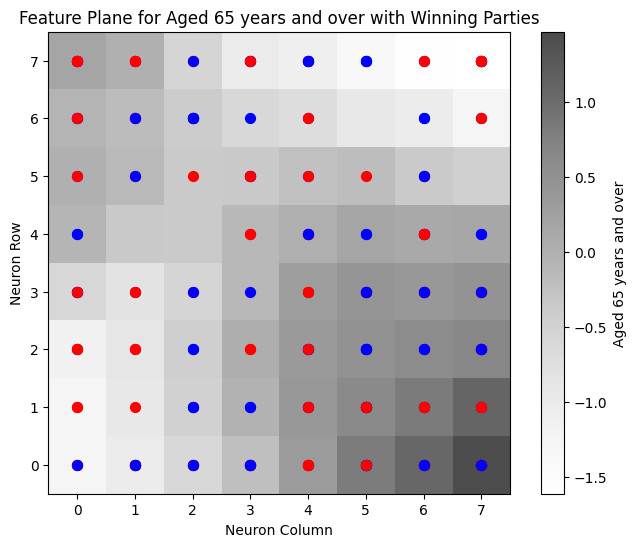

Neuron (5, 6): ['aldershot', 'gateshead', 'kingston upon hull west and hessle']
Neuron (1, 5): ['aldridgebrownhills', 'boston and skegness', 'bury st edmunds', 'dover', 'gosport', 'shrewsbury and atcham', 'south holland and the deepings']
Neuron (7, 1): ['altrincham and sale west', 'epsom and ewell', 'ruislip northwood and pinner', 'south cambridgeshire']
Neuron (2, 5): ['amber valley', 'bassetlaw', 'hastings and rye', 'north durham', 'sedgefield']
Neuron (0, 4): ['ashfield', 'north east somerset', 'redcar', 'rother valley', 'thornbury and yate']
Neuron (6, 4): ['basingstoke', 'finchley and golders green']
Neuron (3, 0): ['bath', 'coventry south', 'norwich south', 'portsmouth south']
Neuron (1, 2): ['batley and spen', 'chatham and aylesford', 'telford']
Neuron (7, 7): ['battersea', 'bermondsey and old southwark', 'islington north', 'islington south and finsbury', 'streatham', 'vauxhall']
Neuron (0, 1): ['birmingham yardley', 'dagenham and rainham', 'edmonton', 'erith and thamesmead', '

In [4]:
#U*-Matrix plotting implementation(Combination of a density matrix and distance matrix)
from scipy.ndimage import median_filter

# This process was emulated from a cited paper within the report of the u*-matrix
u_matrix = som.distance_map()
#plotting the two dimensional grid
density_matrix = np.zeros((n_neurons, m_neurons))

for r, c in zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']):
    density_matrix[r, c] += 1  # Count occurrences

# Normalize density values to avoid division errors
density_matrix = median_filter(density_matrix, size=3)  # Avoid division by zero (Laplace smoothing)

# Step 3: Compute the U*-Matrix
min_p = np.min(density_matrix)
mean_p = np.mean(density_matrix)

if mean_p - min_p == 0:
    scale_factor = np.ones_like(density_matrix)
else:
    scale_factor = (density_matrix - min_p) / (mean_p - min_p)
u_star_matrix = u_matrix * scale_factor

#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U*-Matrix with Overlaid Winning Parties")
plt.imshow(u_star_matrix.T, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar(label="Neuron Distance (U*-Matrix)")
# Overlayying the winning parties on the grid
for _, row in normalized_df.iterrows():
    neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
    party = row['Winning Party']
    vote_share = row['Winning Vote Share']

    if party in party_colors:
        base_color = np.array(party_colors[party])
        adjusted_color = np.clip(base_color * vote_share, 0, 1)

        plt.scatter(neuron_col, #+ 0.3 * np.random.rand(),
                    neuron_row, #+ 0.3 * np.random.rand(),
                    s=vote_share * 100,
                    color=adjusted_color,
                    alpha=0.7, edgecolors='k')

# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()

for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {features.columns[feature_index]} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    for index, row in normalized_df.iterrows():
        neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        winning_party = row['Winning Party']
        if winning_party in party_colors:
          plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=50)

    plt.show()

# Neuron-Constituency Mapping for cluster analysis and understanding
neuron_constituency_map = {}
for index, row in normalized_df.iterrows():
    neuron = (row['Neuron Row'], row['Neuron Col'])
    constituency = row['Westminster Parliamentary constituencies']
    if neuron not in neuron_constituency_map:
        neuron_constituency_map[neuron] = []
    neuron_constituency_map[neuron].append(constituency)

# Print the constituencies mapped to each neuron (optional)
for neuron, constituencies in neuron_constituency_map.items():
    print(f"Neuron {neuron}: {constituencies}")




normalized_df['Neuron'] = list(zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']))
# Party Distribution of the winning neurons with its vote share dataset for analysis
grouped = normalized_df.groupby("Neuron").agg({
    'Winning Party': lambda x: x.value_counts().to_dict(),
    'Winning Vote Share': 'mean',
}).rename(columns={
    'Winning Party': 'Party Distribution',
    'Winning Vote Share': 'Avg Vote Share',
})

print(grouped.head())



